In [1]:
import pandas as pd
import numpy as np
from load_data import load_data

df=load_data("training")
print (df.shape[0])
print(df.query("longitude < 10").shape[0])
ref_df=df.query("longitude > 10")
missing_df=df.query("longitude < 10")

59400
1812


In [2]:
def check_missing_coords(field_name):
    field_values=missing_df[field_name].unique()
    matches=ref_df.query("{0} in @field_values".format(field_name))[field_name].unique()
    print (field_name, field_values.shape[0], matches.shape[0])
    
check_missing_coords("basin")
check_missing_coords("district_code")
check_missing_coords("region")
check_missing_coords("region_code")
check_missing_coords("lga")
check_missing_coords("ward")
check_missing_coords("wpt_name")
check_missing_coords("subvillage")

basin 2 2
district_code 4 4
region 2 2
region_code 3 3
lga 3 2
ward 69 10
wpt_name 1019 339
subvillage 951 231


In [3]:
missing_df.lga.value_counts()

Bariadi    1005
Geita       488
Magu        319
Name: lga, dtype: int64

In [4]:
ref_df.query("lga in ('Bariadi','Geita','Magu')").lga.value_counts()

Magu       505
Bariadi    172
Name: lga, dtype: int64

longitude  0.0033791780745839745
latitude  0.0033752564679009733
missing 1812
found 0
npumps>1 0
lat std nan
lon std nan


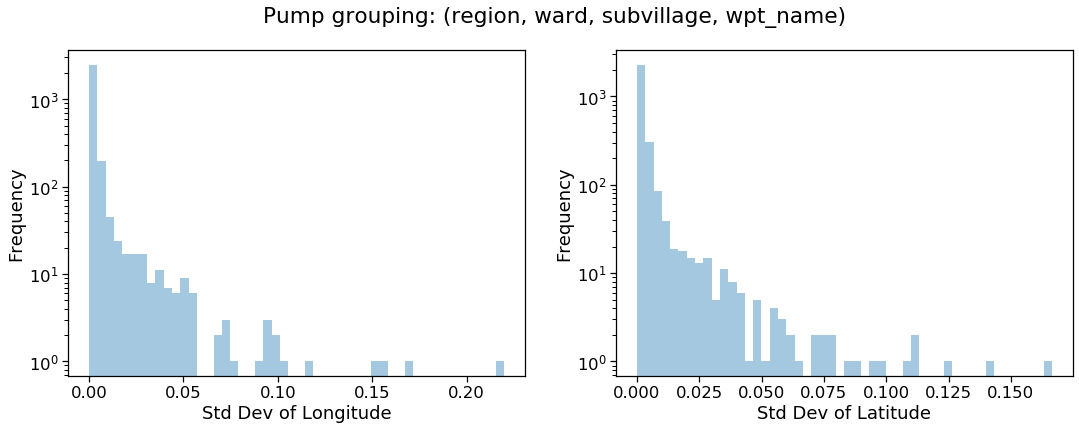

In [53]:
import seaborn as sns
from haversine import haversine
from matplotlib import pyplot as plt
%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3})
def calc_precision(row):
    p1=(row.latitude_mean,
        row.longitude_mean)
    p2=(row.latitude_mean + row.latitude_std,
        row.longitude_mean + row.longitude_std)

    return haversine(p1,p2) #default return unit is km

def make_map(region_fields, do_plots=False):
    geo_map=ref_df.groupby(region_fields).\
                   agg(npumps=("id","count"),
                       latitude_mean=("latitude","mean"),
                       longitude_mean=("longitude","mean"),
                       latitude_std=("latitude","std"),
                       longitude_std=("longitude","std")).\
                   reset_index()
    
    geo_map["precision"] = geo_map.apply(calc_precision, axis=1)
    
    err_map=geo_map.query("npumps>1")
    geo_map["precision"].fillna(err_map.precision.mean(), inplace=True)
    if do_plots:
        f,a=plt.subplots(1,2, figsize=(18,6))
        region_spec=', '.join(region_fields)
        title="Pump grouping: ({})".format(region_spec) 
        f.suptitle(title)
        glong=sns.distplot(err_map.longitude_std, kde=False, ax=a[0])
        glat=sns.distplot(err_map.latitude_std, kde=False, ax=a[1])
        glat.set(yscale="log", xlabel="Std Dev of Latitude", ylabel="Frequency")
        glong.set(yscale="log", xlabel="Std Dev of Longitude", ylabel="Frequency")
        fig_name = "figs/coord_precision/{}.png".format(region_spec.replace(", ","_"))
        f.savefig(fig_name)
    print ("longitude ", err_map.longitude_std.mean())
    print ("latitude ", err_map.latitude_std.mean())
    return geo_map

def get_keys(m):
    data_fields=["npumps","precision","longitude_mean","longitude_std","latitude_mean","latitude_std"]
    keys = [c for c in m.columns if c not in data_fields]
    return keys
    
def check_matches(ref_map):
    print ("missing",missing_df.shape[0])
    keys = get_keys(ref_map)
    found=missing_df.merge(ref_map,on=keys)
    print ("found",found.shape[0])
    print ("npumps>1",found.query("npumps>1").shape[0])
    print ("lat std",found.query("npumps>1").latitude_std.mean())
    print ("lon std",found.query("npumps>1").longitude_std.mean())
    return found
m1=make_map(["region","ward","subvillage","wpt_name"],do_plots=True)
f1=check_matches(m1)

longitude  0.004437762611917028
latitude  0.004654159281907131
missing 1812
found 16
npumps>1 13
lat std 0.028780369091230308
lon std 0.0259615216871026


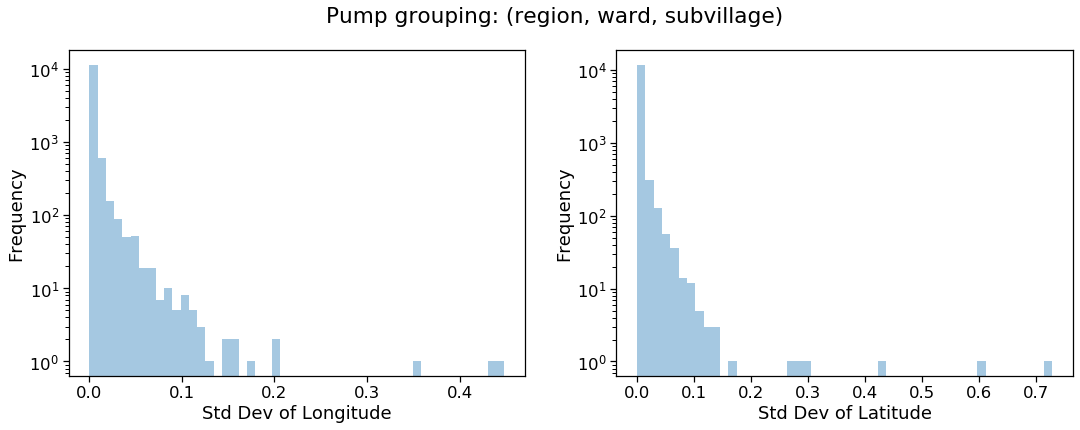

In [54]:
m2=make_map(["region","ward","subvillage"],do_plots=True)
f2=check_matches(m2)

longitude  0.0051947524418914535
latitude  0.0053014340825909695
missing 1812
found 16
npumps>1 13
lat std 0.028780369091230308
lon std 0.0259615216871026


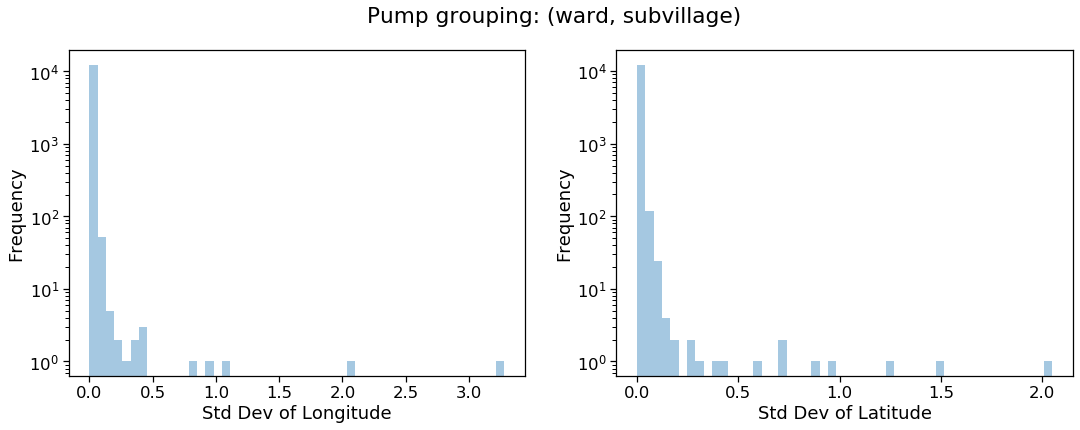

In [58]:
m6=make_map(["ward","subvillage"],do_plots=True)
f6=check_matches(m6)

longitude  0.02994031626962088
latitude  0.030863997547321245
missing 1812
found 191
npumps>1 191
lat std 0.09893997778733003
lon std 0.10946150601098058


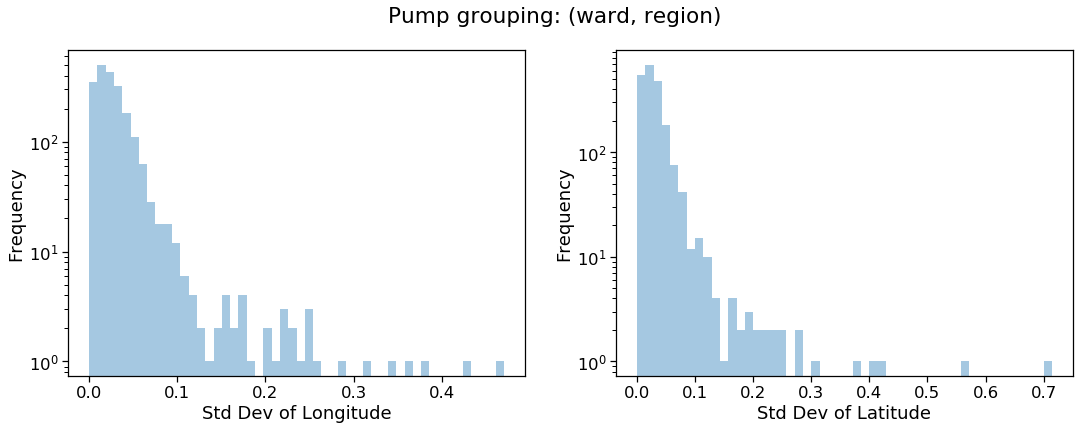

In [59]:
m7=make_map(["ward","region"],do_plots=True)
f7=check_matches(m7)

longitude  0.03191312466049791
latitude  0.031155541638967083
missing 1812
found 206
npumps>1 206
lat std 0.01680920000285433
lon std 0.020713802459019503


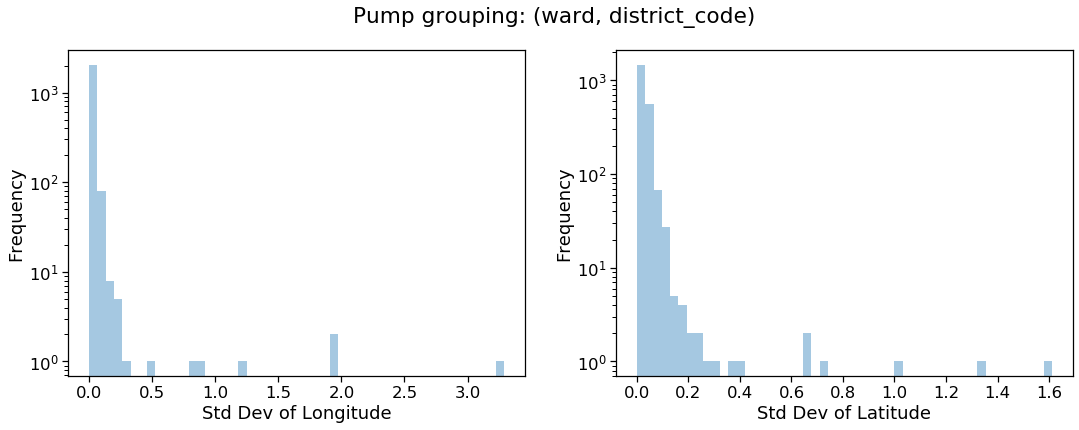

In [78]:
m8=make_map(["ward","district_code"],do_plots=True)
f8=check_matches(m8)

longitude  0.059581290596841564
latitude  0.05652514382532105
missing 1812
found 354
npumps>1 354
lat std 0.09336073097473474
lon std 0.07697680533226686


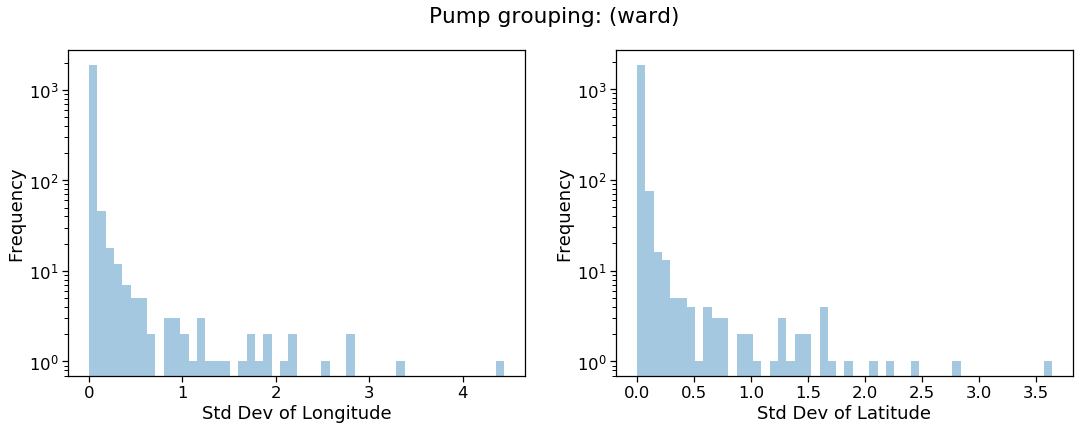

In [61]:
m9=make_map(["ward"],do_plots=True)
f9=check_matches(m9)

longitude  0.46328929156119175
latitude  0.49406756824986797
missing 1812
found 1812
npumps>1 1812
lat std 0.32916261987723294
lon std 0.5712513897133642


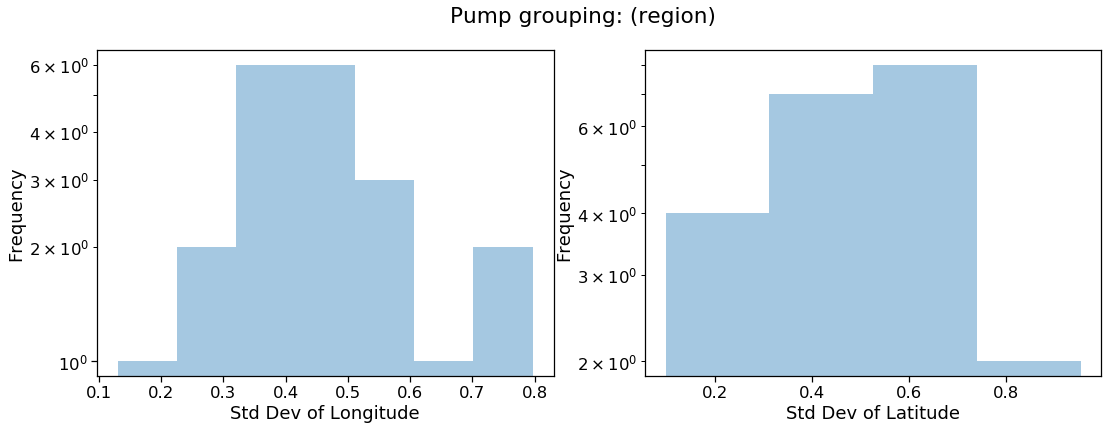

In [62]:
m10=make_map(["region"],do_plots=True)
f10=check_matches(m10)

longitude  0.16829023497853876
latitude  0.18045981024214416
missing 1812
found 1324
npumps>1 1324
lat std 0.05696915877119367
lon std 0.1466878937454728


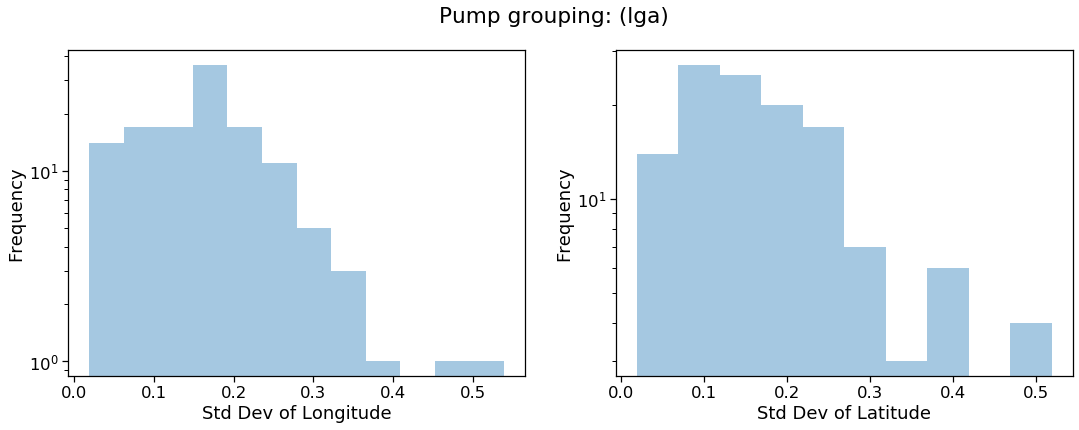

In [63]:
m11=make_map(["lga"],do_plots=True)
f11=check_matches(m11)

In [16]:
m5.head()

,region,npumps,latitude_mean,longitude_mean,latitude_std,longitude_std,precision
0,Arusha,3350,-3.246455,36.552713,0.297856,0.461240,60.989197
1,Dar es Salaam,805,-6.909677,39.215799,0.097479,0.130179,18.000796
2,Dodoma,2201,-5.928734,36.044171,0.679469,0.385737,86.779095
3,Iringa,5294,-8.907700,34.895989,0.695036,0.507484,95.323767
4,Kagera,3316,-1.961466,31.233262,0.636347,0.425853,85.130494


In [17]:
from haversine import haversine
haversine((-3.246455,36.552713), (-4,37.352713))

122.07502184157991

In [77]:
geo_maps=[]
geo_maps.append(make_map(["region","ward","subvillage"]))
geo_maps.append(make_map(["ward","district_code"]))
geo_maps.append(make_map(["lga"]))
geo_maps.append(make_map(["region"]))


longitude  0.004437762611917028
latitude  0.004654159281907131
longitude  0.03191312466049791
latitude  0.031155541638967083
longitude  0.16829023497853876
latitude  0.18045981024214416
longitude  0.46328929156119175
latitude  0.49406756824986797


In [19]:
geo_maps[1].head()

,region,ward,wpt_name,npumps,latitude_mean,longitude_mean,latitude_std,longitude_std,precision
0,Arusha,Akheri,Afitwa,1,-3.353248,36.779412,NaN,NaN,2.631485
1,Arusha,Akheri,Akeri Primary School,3,-3.346495,36.776384,0.000397,0.000123,0.046154
2,Arusha,Akheri,Alexander,1,-3.342536,36.772493,NaN,NaN,2.631485
3,Arusha,Akheri,Aseri,1,-3.347883,36.771630,NaN,NaN,2.631485
4,Arusha,Akheri,Chuo Cha Ualimu,4,-3.369473,36.782075,0.000389,0.000420,0.063617


In [79]:
def calc_approx_coords(pump):
    pump=pd.DataFrame(pump).transpose()
    best_match=None
    for m in geo_maps:
        keys=get_keys(m)
        match=pump.merge(m,on=keys)
        if match.shape[0]>1:
            print ("ERROR multiple matches for ", keys)
        elif match.shape[0]==0:
            continue
        match=match.loc[0]
        
        if best_match is None:
            best_match=match
        elif match.precision < best_match.precision:
            best_match=match


            
    result_cols=["id","latitude_mean","longitude_mean","precision"]
    rename_map={"latitude_mean":"approx_latitude",
                "longitude_mean":"approx_longitude",
                "precision":"loc_precision"}
    results=best_match[result_cols].rename(rename_map)
    return results
            
approx_coords=missing_df.apply(calc_approx_coords,axis=1)

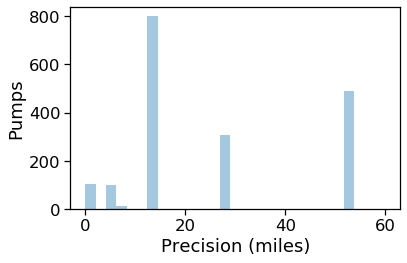

In [85]:
g=sns.distplot(approx_coords.loc_precision,kde=False, bins=np.linspace(0.0,60.0,30))
g.set(xlabel="Precision (miles)",ylabel=("Pumps"))
plt.tight_layout()
g.get_figure().savefig("figs/coord_precision/summary_precision.png")

In [23]:
out_df = df.merge(approx_coords, on="id", how="left")
out_df.approx_latitude  = out_df.approx_latitude.combine_first(out_df.latitude)
out_df.approx_longitude = out_df.approx_longitude.combine_first(out_df.longitude)
out_df.loc_precision    = out_df.loc_precision.fillna(0)

In [26]:
print (df.shape)
print (out_df.shape)

(59400, 43)
(59400, 46)


In [27]:
missing_flags=out_df.longitude < 10
print(out_df[missing_flags].longitude.unique())
print(out_df[missing_flags].latitude.unique())

[0.]
[-2.e-08]


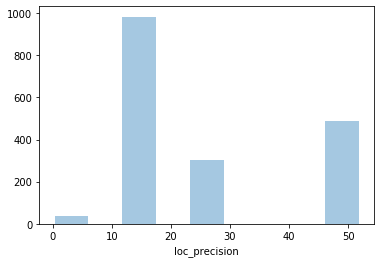

In [28]:
sns.distplot(out_df[missing_flags].loc_precision,kde=False)

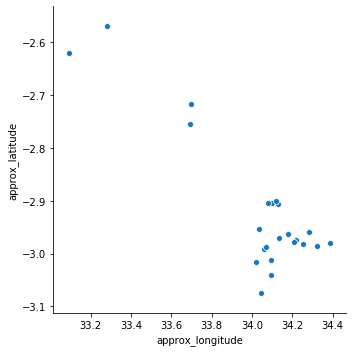

In [30]:
sns.relplot(data=out_df[missing_flags],x="approx_longitude",y="approx_latitude")

In [33]:
out_df[missing_flags].query("loc_precision > 10").shape

(1772, 46)

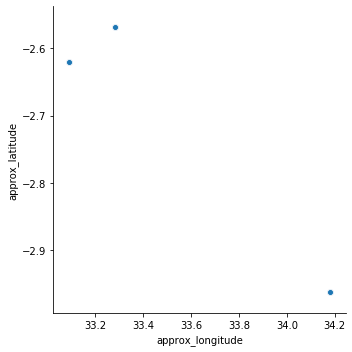

In [32]:
sns.relplot(data=out_df[missing_flags].query("loc_precision > 10"),x="approx_longitude",y="approx_latitude")

(40, 46)


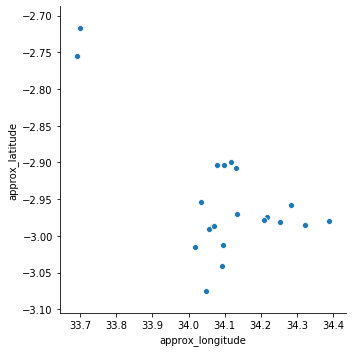

In [34]:
print (out_df[missing_flags].query("loc_precision < 10").shape)
sns.relplot(data=out_df[missing_flags].query("loc_precision < 10"),x="approx_longitude",y="approx_latitude")

In [39]:
print(out_df[missing_flags].query("latitude==approx_latitude").shape)
print(out_df[missing_flags].query("longitude==approx_longitude").shape)


(0, 46)
(0, 46)


In [41]:
print(out_df[~missing_flags].shape)
print(out_df[~missing_flags].query("latitude==approx_latitude").shape)
print(out_df[~missing_flags].query("longitude==approx_longitude").shape)

(57588, 46)
(57588, 46)
(57588, 46)


In [ ]:
df.groupby()